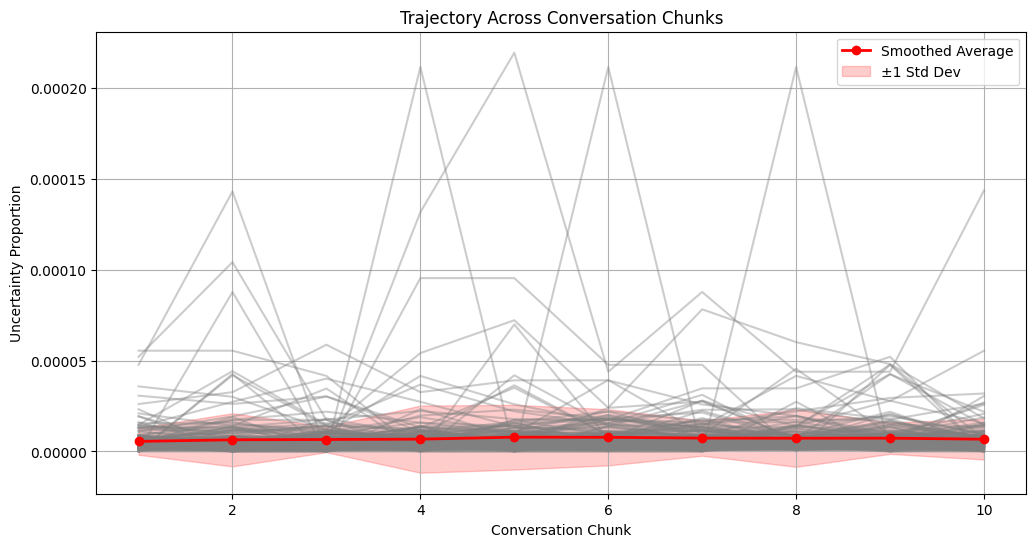

TypeError: line() got an unexpected keyword argument 'opacity'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

csv_file = "uncertainty_strong_matrix.csv"  # Path to CSV
focus = "uncertainty"
smoothing_window = 2     

# Load your CSV
df = pd.read_csv(csv_file)

# Detect conversation chunk columns
conv_chunks = [col for col in df.columns if col.startswith('chunk_')]

# Melt dataframe for plotting 
df_long = df.melt(id_vars=['filename'], 
                  value_vars=conv_chunks, 
                  var_name='chunk', 
                  value_name=focus)

# Convert chunk to numeric for plotting
df_long['chunk_numeric'] = df_long['chunk'].str.replace('chunk_', '').astype(int)

# -----------------------------
# 4. COMPUTE SMOOTHED AVERAGE
# -----------------------------
avg_trajectory = df_long.groupby('chunk_numeric')[focus].mean().reset_index()
avg_trajectory['value_smooth'] = avg_trajectory[focus].rolling(window=smoothing_window, min_periods=1).mean()

# ±1 standard deviation for variability
std_trajectory = df_long.groupby('chunk_numeric')[focus].std().reset_index()
avg_trajectory['upper'] = avg_trajectory['value_smooth'] + std_trajectory[focus]
avg_trajectory['lower'] = avg_trajectory['value_smooth'] - std_trajectory[focus]

# -----------------------------
# 5a. STATIC MATPLOTLIB PLOT
# -----------------------------
plt.figure(figsize=(12,6))

# Individual conversation lines
for conv_id, group in df_long.groupby('filename'):
    plt.plot(group['chunk_numeric'], group[focus], color='gray', alpha=0.4)

# Smoothed average
plt.plot(avg_trajectory['chunk_numeric'], avg_trajectory['value_smooth'],
         color='red', marker='o', linewidth=2, label='Smoothed Average')

# Confidence interval
plt.fill_between(avg_trajectory['chunk_numeric'], avg_trajectory['lower'], avg_trajectory['upper'],
                 color='red', alpha=0.2, label='±1 Std Dev')

plt.title("Trajectory Across Conversation Chunks")
plt.xlabel("Conversation Chunk")
plt.ylabel((f"{focus} proportion").title())
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 5b. INTERACTIVE PLOTLY PLOT
# -----------------------------
fig = px.line(df_long, x='chunk_numeric', y=focus, color='filename',
              title='Trajectory Across Conversation Time',
              labels={'chunk_numeric':'Decile of Conversation Time',focus:(f"{focus} proportion").title()},
              opacity=0.3)

# Smoothed average
fig.add_scatter(x=avg_trajectory['chunk_numeric'], y=avg_trajectory['value_smooth'],
                mode='lines+markers', line=dict(color='red', width=3),
                name='Smoothed Average')

# Confidence interval
fig.add_scatter(x=avg_trajectory['chunk_numeric'], y=avg_trajectory['upper'],
                mode='lines', line=dict(color='red', width=0), fill=None, showlegend=False)
fig.add_scatter(x=avg_trajectory['chunk_numeric'], y=avg_trajectory['lower'],
                mode='lines', line=dict(color='red', width=0), fill='tonexty', fillcolor='rgba(255,0,0,0.2)',
                name='±1 Std Dev')

fig.show()
